In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns

In [3]:
df = pd.read_parquet('/home/t9s9/Documents/Uni/MMC-PR/eaf_f0_events.parquet')

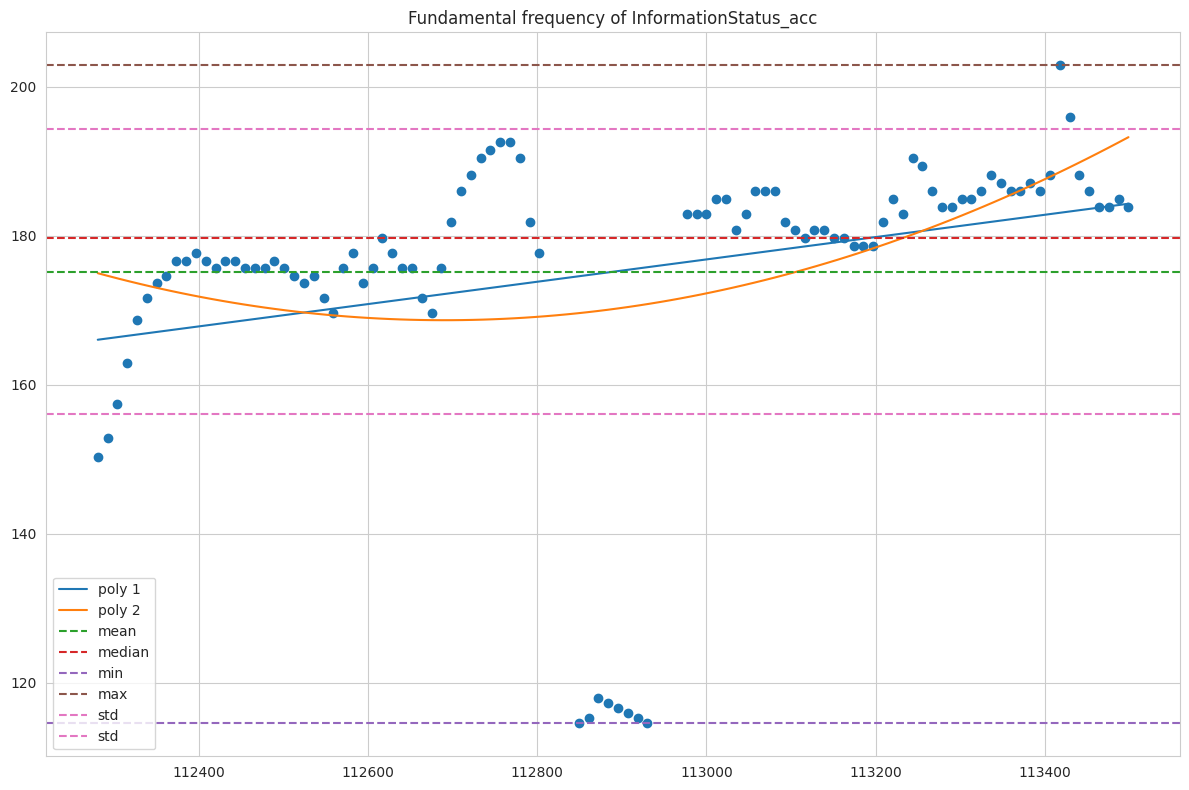

In [121]:
# dp = df[df.tier == 'Pitch accents'].iloc[3]
dp = df[df.tier == 'InformationStatus'].iloc[51]

cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(dp.times, dp.f0)
x = np.linspace(dp.times.min(), dp.times.max(), num=100)
y = dp.slope1_1 * x + dp.intercept1_1
ax.plot(x, y, label='poly 1')
y = dp.slope2_1 * x**2 + dp.slope2_2 * x + dp.intercept2_1
ax.plot(x, y, label='poly 2')

for i, stat in enumerate(['mean', 'median', 'min', 'max']):
    ax.axhline(y=dp[stat], label=stat, color=cmap(2+i), linestyle = '--')

ax.axhline(y=dp['mean'] + dp['std'], label='std', color=cmap(3+i), linestyle = '--')
ax.axhline(y=dp['mean'] - dp['std'], label='std', color=cmap(3+i), linestyle = '--')
plt.legend()
plt.title(f'Fundamental frequency of {dp.nn}')
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='annot'>

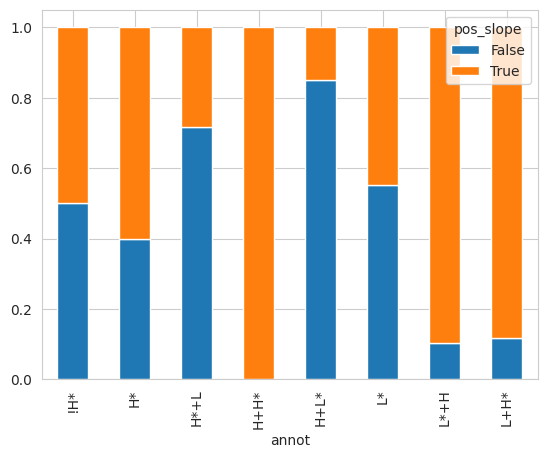

In [12]:
df_pitch = df[df.tier == 'Pitch accents'].drop(columns=['tier', 'nn', 'start', 'stop', 'f0', 'times'])
df_pitch.annot = df_pitch.annot.replace({'H': 'H*', '!H+': '!H*', 'L*H*': 'L+H*'}).astype('category')
df_pitch = df_pitch.dropna()

df_pitch['pos_slope'] = df_pitch['slope1_1'] > 0
df_pitch.groupby('annot').pos_slope.value_counts(normalize=True).unstack().plot.bar(stacked=True)

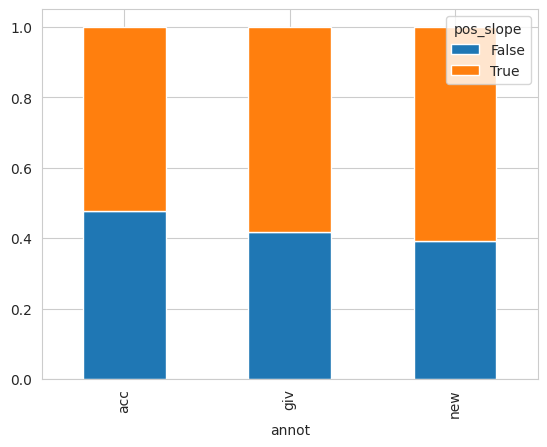

In [41]:
df_info = df[df.tier == 'InformationStatus'].drop(columns=['tier', 'nn', 'start', 'stop', 'f0', 'times'])
df_info.annot = df_info.annot.replace({'accc': 'acc', 'ycc': 'acc', 'ac': 'acc'}).astype('category')
df_info = df_info.dropna()

df_info['pos_slope'] = df_info['slope1_1'] > 0
df_info.groupby('annot').pos_slope.value_counts(normalize=True).unstack().plot.bar(stacked=True)
df_info = df_info.drop(columns=['pos_slope'])

In [59]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_raw, y_raw = df_info.drop(columns=['annot']), df_info.annot
print(y_raw.value_counts())

X = StandardScaler().fit_transform(X_raw)
y = OrdinalEncoder().fit_transform(y_raw.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

acc    2124
giv    1500
new    1414
Name: annot, dtype: int64
(4030, 10) (1008, 10) (4030,) (1008,)


In [55]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_leaf_nodes=50).fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))

0.6605459057071961 0.5525793650793651


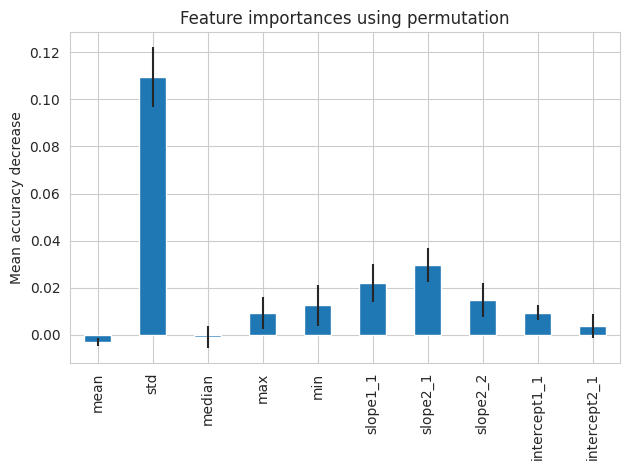

In [56]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean, index=list(X_raw.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()